# Comparação de Modelos de Machine Learning

In [56]:
import os
import pickle
from collections import Counter
import pandas as pd

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split, HalvingGridSearchCV, GridSearchCV, 
    cross_val_score, learning_curve, validation_curve, KFold
)
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, auc, make_scorer
)

import umap.umap_ as umap

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


## Dataset Fruits-360

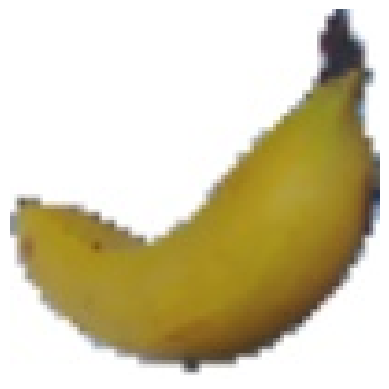

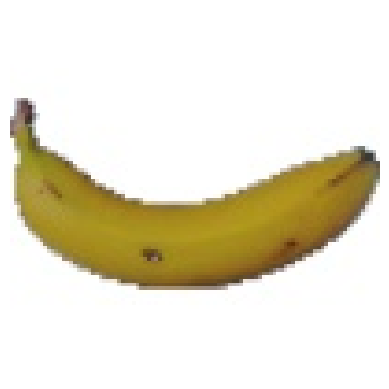

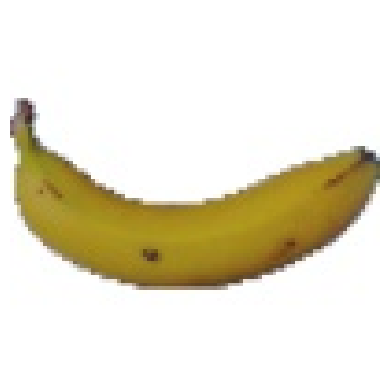

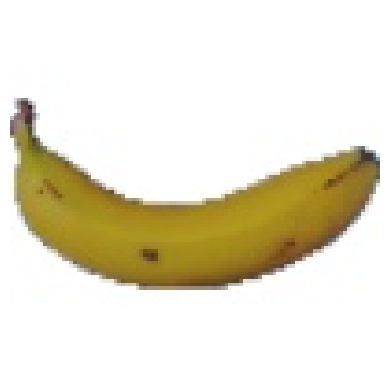

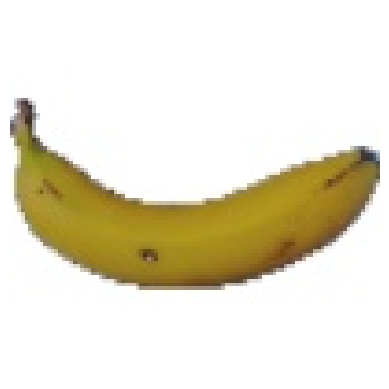

In [57]:
dataset_path = "fruits_dataset/fruits-test"
IMAGE_SIZE = (100, 100)
BATCH_SIZE = 500  # Treino em lotes
DATA_AUGMENTATION = True
NUM_CLASSES = 7

def visualize_samples(path, num_samples=5):
    sample_path = os.path.join(path, "Banana 1")
    sample_images = os.listdir(sample_path)[:num_samples]
    for img in sample_images:
        image = Image.open(os.path.join(sample_path, img))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

visualize_samples(dataset_path)

## Pré-processamento do Dataset

In [58]:
# Criar gerador de imagens para Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True
)

def load_images_and_labels(dataset_path):
    X, y = [], []
    label_encoder = LabelEncoder()

    fruit_dirs = os.listdir(dataset_path)
    label_encoder.fit(fruit_dirs)

    for fruit_dir in fruit_dirs:
        fruit_path = os.path.join(dataset_path, fruit_dir)
        img_files = os.listdir(fruit_path)

        for img_file in img_files:
            img_path = os.path.join(fruit_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Erro ao carregar imagem: {img_path}")
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            img = img.astype(np.float32) / 255.0  # Normalização [0,1]
            X.append(img.flatten())  # Vetorização
            y.append(fruit_dir)

    return np.array(X), label_encoder.transform(y), label_encoder

# Carregar imagens e rótulos
X, y, label_encoder = load_images_and_labels(dataset_path)

# Dividir dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar Data Augmentation apenas no conjunto de treino
if DATA_AUGMENTATION:
    X_train_augmented, y_train_augmented = [], []
    X_train_reshaped = X_train.reshape(-1, 100, 100, 3)

    # Gerar novas imagens até atingir o número desejado
    aug_batches = data_gen.flow(X_train_reshaped, y_train, batch_size=BATCH_SIZE, shuffle=False)

    for i in range(len(X_train) // BATCH_SIZE):  # Gera apenas a quantidade correta de amostras
        X_batch, y_batch = next(aug_batches)
        X_train_augmented.extend(X_batch.reshape(X_batch.shape[0], -1))
        y_train_augmented.extend(y_batch)

    X_train_augmented = np.array(X_train_augmented)
    y_train_augmented = np.array(y_train_augmented)

    # Certificar que o número de amostras bate antes de concatenar
    min_samples = min(len(X_train_augmented), len(y_train))
    X_train = np.vstack((X_train, X_train_augmented[:min_samples]))
    y_train = np.hstack((y_train, y_train_augmented[:min_samples]))

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduzir dimensionalidade com UMAP
umap_reducer = umap.UMAP(n_components=50, random_state=42)
X_train_umap = umap_reducer.fit_transform(X_train_scaled, y_train)
X_test_umap = umap_reducer.transform(X_test_scaled)

c:\Users\hagaf\OneDrive\Desktop\Projetos-GitHub\RP-RN-2024.2\env\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


KeyboardInterrupt: 

Distribuição de Classes: Counter({5: 984, 3: 936, 0: 656, 1: 656, 4: 656, 6: 656, 2: 600})


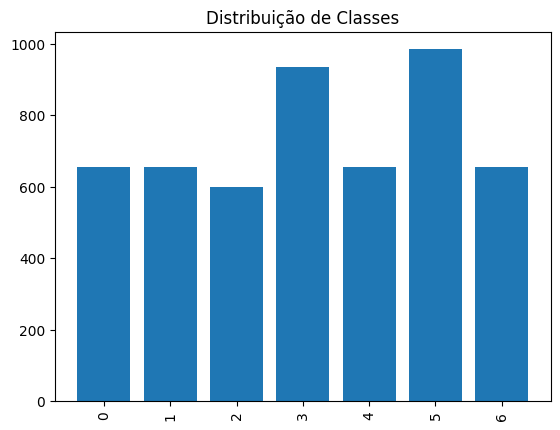

In [ ]:
class_distribution = Counter(y)
print("Distribuição de Classes:", class_distribution)
sorted_classes = sorted(class_distribution.keys())
plt.bar(sorted_classes, [class_distribution[c] for c in sorted_classes])
plt.xticks(rotation=90)
plt.title("Distribuição de Classes")
plt.show()

## Funções de Avaliação

In [ ]:
# Função para plotar a curva ROC para cada classe
def plot_multiclass_roc(y_test_bin, y_score, model_name): 
    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linha de referência
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Binarizar rótulos (One-hot encoding)
n_classes = len(np.unique(y_test))  # Número de classes únicas
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))  # Torna (901,) -> (901, n_classes)

In [ ]:
def plot_error_2d(errors, title):
    plt.scatter(errors[:, 0], errors[:, 1], color='red', label='Erros')
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend()
    plt.show()

In [ ]:
def plot_learning_curve(train_sizes, train_mean, test_mean, title):
    plt.plot(train_sizes, train_mean, label='Treinamento', color='blue')
    plt.plot(train_sizes, test_mean, label='Validação', color='orange')
    plt.xlabel('Tamanho do Conjunto de Treinamento')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def plot_validation_curve(param_range, train_mean, test_mean, title):
    plt.plot(param_range, train_mean, label='Treinamento', color='blue')
    plt.plot(param_range, test_mean, label='Validação', color='orange')
    plt.xlabel('Parâmetro C')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

param_range = [0.1, 1, 10, 100]

# SVM

In [ ]:
# Classificação usando SVM

# Primeiro param_grid testado
# param_grid = {
#     'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'degree': [2, 3, 4], # if 'poly'
#     'gamma': ['scale', 'auto', 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
# }
# Maior parte dos experimentos deu C = 100 e kernel = 'linear' e gamma varia de 5-10

# Segundo param_grid testado
# param_grid = {
#     'C': [100],
#     'kernel': ['linear'],
#     'gamma': [5, 6, 7, 8, 9, 10]
# }

# Halving Search
# halving_search = HalvingGridSearchCV(SVC(), param_grid, factor=2, cv=5)
# halving_search.fit(X_train_umap, y_train)
# print("Melhores hiperparâmetros:", halving_search.best_params_)

# Parâmetros escolhidos
param_grid = {
    'C': [100],
    'kernel': ['linear'],
    'gamma': [9]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train_umap, y_train)
best_svm = grid_search.best_estimator_
svm_predictions = best_svm.predict(X_test_umap)

SVM Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       131
           1       1.00      0.99      1.00       131
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       188
           4       1.00      1.00      1.00       131
           5       0.99      1.00      1.00       197
           6       0.99      1.00      1.00       131

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029
 

SVM Test Accuracy: 0.9980563654033042 

Melhor score na validação cruzada: 0.9993838570548368


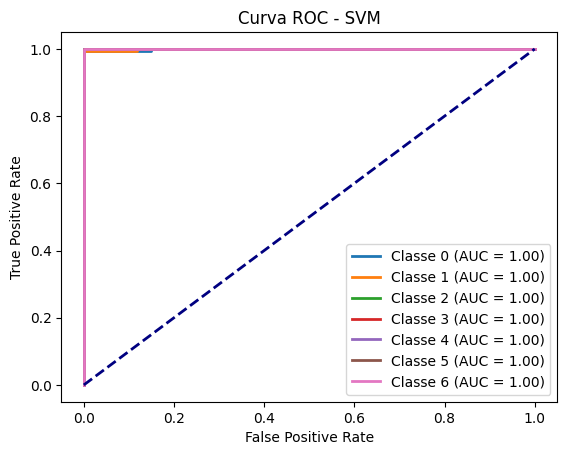

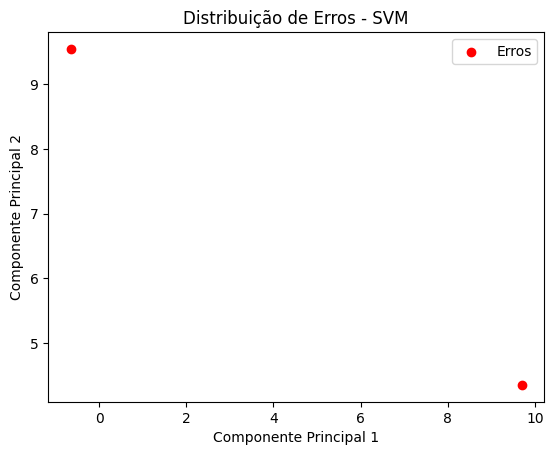

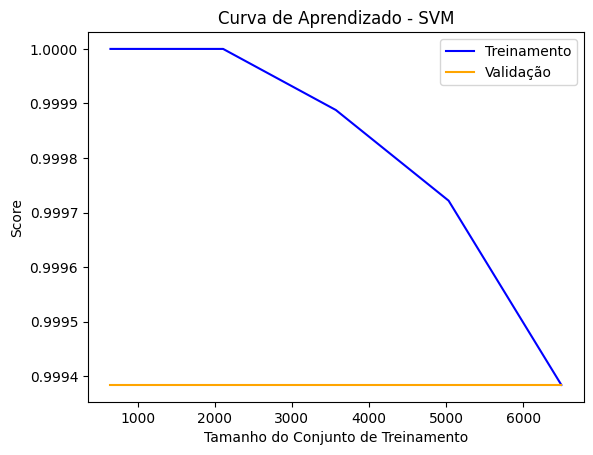

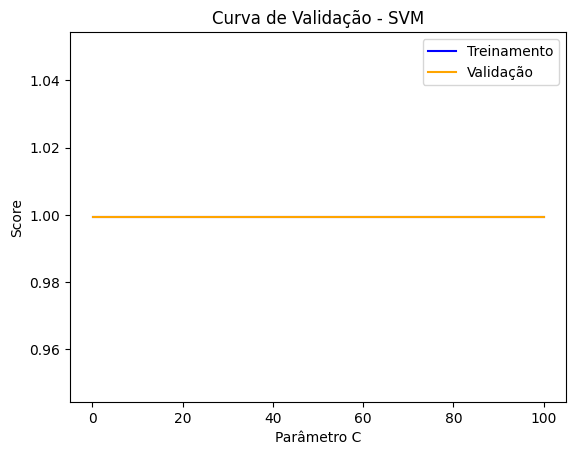

In [ ]:
# Avaliação do SVM
print("SVM Test Classification Report:")
print(classification_report(y_test, svm_predictions), "\n")
print("SVM Test Accuracy:", accuracy_score(y_test, svm_predictions), "\n")

# Validação cruzada
print("Melhor score na validação cruzada:", grid_search.best_score_)

# Encontrar amostras mal classificadas corretamente
errors_svm = X_test_umap[np.where(y_test != svm_predictions)]

# Probabilidades preditas pelos modelos
y_score_svm = best_svm.decision_function(X_test_umap)

# Plotar curvas ROC para cada modelo
plot_multiclass_roc(y_test_bin, y_score_svm, "SVM")

# Plotar os erros para cada modelo
plot_error_2d(errors_svm, "Distribuição de Erros - SVM")

train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(best_svm, X_train_umap, y_train, cv=5)
train_mean_svm = train_scores_svm.mean(axis=1)
test_mean_svm = test_scores_svm.mean(axis=1)
plot_learning_curve(train_sizes_svm, train_mean_svm, test_mean_svm, "Curva de Aprendizado - SVM")

train_scores_vc_svm, test_scores_vc_svm = validation_curve(SVC(), X_train_umap, y_train, param_name="C", param_range=param_range, cv=5)
train_mean_vc_svm = train_scores_vc_svm.mean(axis=1)
test_mean_vc_svm = test_scores_vc_svm.mean(axis=1)
plot_validation_curve(param_range, train_mean_vc_svm, test_mean_vc_svm, "Curva de Validação - SVM")

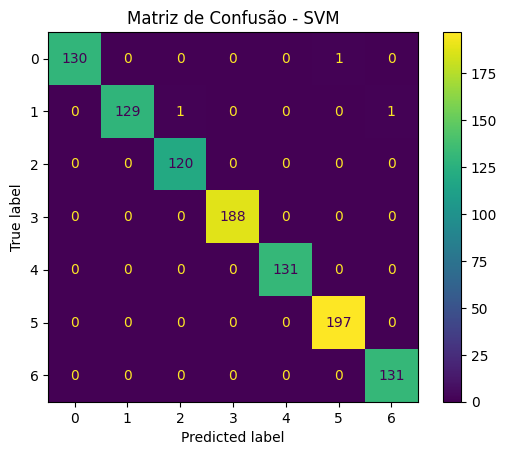

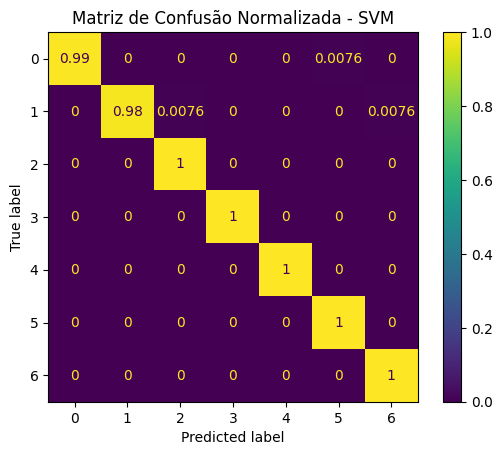

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_svm, X_test_umap, y_test)
plt.title("Matriz de Confusão - SVM")
plt.show()

ConfusionMatrixDisplay.from_estimator(best_svm, X_test_umap, y_test, normalize='true')
plt.title("Matriz de Confusão Normalizada - SVM")
plt.show()

In [ ]:
import pickle

# Salva características e o modelo treinado para uso posterior
with open("svm_model_and_features.pkl", "wb") as f:
    pickle.dump({
        "X_train_umap": X_train_umap,
        "X_test_umap": X_test_umap,
        "y_train": y_train,
        "y_test": y_test,
        "best_svm": best_svm
    }, f)

print("Modelo SVM e características salvos com sucesso!")

# CNN

In [ ]:
# Convertendo os rótulos para one-hot encoding
y_train_cnn = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cnn = to_categorical(y_test, num_classes=NUM_CLASSES)

# Reconstruir as imagens no formato (100, 100, 3) para o MobileNet
X_train_reshaped_reshaped = X_train.reshape(-1, 100, 100, 3)
X_test_reshaped_reshaped = X_test.reshape(-1, 100, 100, 3)

In [ ]:
# Construir a CNN
cnn_model = Sequential()

# Camada convolucional + max pooling
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Achatar a saída para alimentar as camadas densas
cnn_model.add(Flatten())

# Camada densa totalmente conectada
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.7))

# Camada de saída com ativação softmax para classificação multiclasse
cnn_model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compilando o modelo com as métricas desejadas
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Treinando o modelo
history = cnn_model.fit(X_train_reshaped_reshaped, y_train_cnn,
                        epochs=20, batch_size=32,
                        validation_data=(X_test_reshaped_reshaped, y_test_cnn))

ModuleNotFoundError: No module named 'scikeras'

33/33 [==============================] - 4s 108ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       131
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       188
           4       1.00      1.00      1.00       131
           5       1.00      1.00      1.00       197
           6       1.00      1.00      1.00       131

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029

CNN Accuracy: 1.0


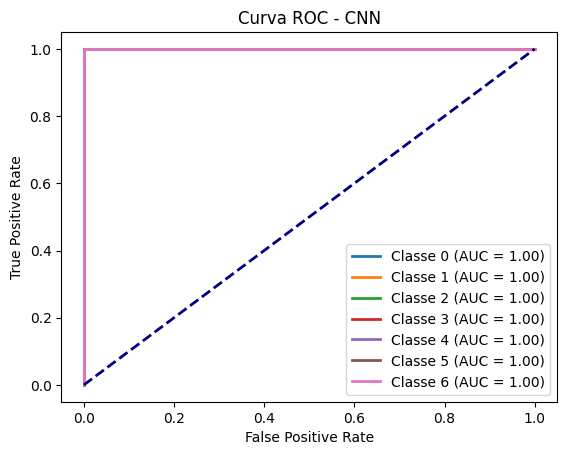

C:\Users\hagaf\AppData\Local\Temp\ipykernel_32300\833356154.py:24: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  errors_cnn = X_test_pca_cnn[np.where(y_test_cnn != y_test_cnn_classes)]


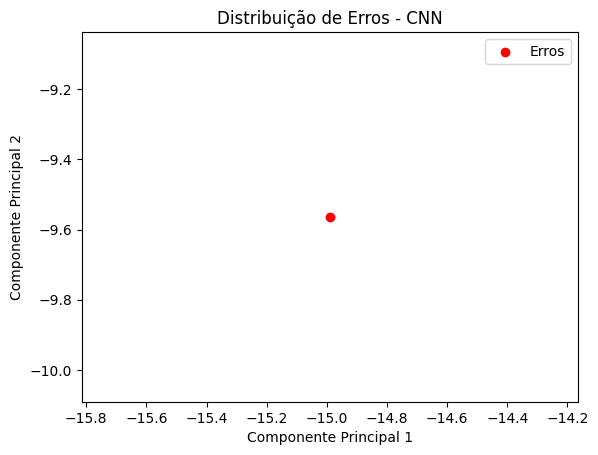

In [ ]:
# Fazer previsões no conjunto de teste
y_pred_cnn = cnn_model.predict(X_test_reshaped_reshaped)

# Converter probabilidades em classes (índices da classe prevista)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Converter os rótulos reais (one-hot encoded) de volta para índices
y_test_cnn_classes = np.argmax(y_test_cnn, axis=1)

# Gerar o relatório de classificação
print("CNN Classification Report:")
print(classification_report(y_test_cnn_classes, y_pred_cnn_classes))

# Acurácia do modelo
print("CNN Accuracy:", accuracy_score(y_test_cnn_classes, y_pred_cnn_classes))

plot_multiclass_roc(y_test_bin, y_pred_cnn, "CNN")

# Reduzir dimensionalidade com PCA para visualização
pca = PCA(n_components=2)
X_test_pca_cnn = pca.fit_transform(X_test.reshape(X_test.shape[0], -1))

# Encontrar amostras mal classificadas
errors_cnn = X_test_pca_cnn[np.where(y_test_cnn != y_test_cnn_classes)]

plot_error_2d(errors_cnn, "Distribuição de Erros - CNN")

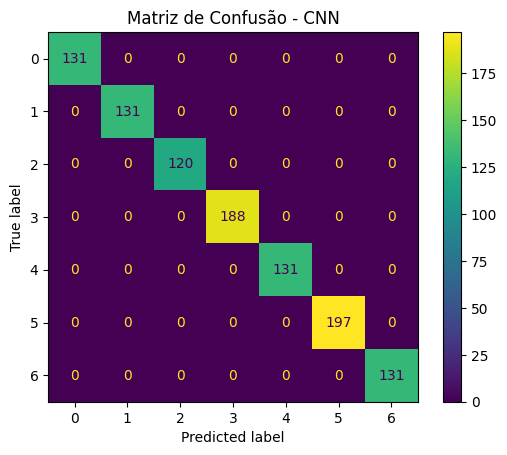

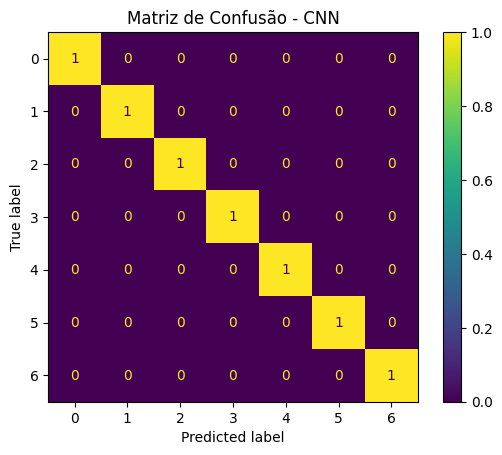

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_cnn_classes, y_pred_cnn_classes)
plt.title("Matriz de Confusão - CNN")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test_cnn_classes, y_pred_cnn_classes, normalize='true')
plt.title("Matriz de Confusão - CNN")
plt.show()

# MobileNet
O MobileNet é uma rede neural leve e eficiente, ideal para classificação de imagens em dispositivos com recursos limitados. Ele usa convoluções separáveis para reduzir custos computacionais e memória, mantendo boa precisão. Pré-treinado no ImageNet, é fácil adaptá-lo via transfer learning para tarefas específicas, como classificação de frutas. Comparado ao SVM, ele aprende características automaticamente e escala melhor para grandes volumes de dados. É uma escolha robusta para aplicações em tempo real e comparações com modelos clássicos.

In [59]:
# Obs.: Normalização e redução de dimensionalidade (UMAP) não são necessário para MobileNet,
# por isso é necessário restourar as imagens para o formato (100, 100, 3) antes de treinar o modelo.

# Reconstruir as imagens no formato (100, 100, 3) para o MobileNet
X_train_reshaped_reshaped = X_train.reshape(-1, 100, 100, 3)
X_test_reshaped_reshaped = X_test.reshape(-1, 100, 100, 3)

In [ ]:
# Carregar o modelo MobileNet pré-treinado (sem a camada fully connected no topo)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Adicionar camadas personalizadas no topo do modelo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar as camadas do MobileNet para evitar que sejam treinadas
for layer in base_model.layers:
    layer.trainable = False

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train_reshaped_reshaped, y_train, batch_size=32, epochs=13, validation_data=(X_test_reshaped_reshaped, y_test))

# Fazer previsões
y_pred = model.predict(X_test_reshaped_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Avaliação do MobileNet
print("MobileNet Classification Report:")
print(classification_report(y_test, y_pred_classes))
print("MobileNet Accuracy:", accuracy_score(y_test, y_pred_classes))

# Validação cruzada com MobileNet (não é comum para redes neurais, mas pode ser feito)
# Pode ser utilizado KFold manualmente ou outras técnicas de validação cruzada.

Epoch 1/13
254/254 [==============================] - 92s 342ms/step - loss: 0.0592 - accuracy: 0.9826 - val_loss: 3.9866e-04 - val_accuracy: 1.0000
Epoch 2/13
254/254 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983

In [ ]:
# Acurácia do treino
train_predictions = np.argmax(model.predict(X_train_reshaped_reshaped), axis=1)
train_accuracy = accuracy_score(y_train, train_predictions)
print("MobileNet Train Accuracy:", train_accuracy)

# Acurácia do teste
test_predictions = np.argmax(model.predict(X_test_reshaped_reshaped), axis=1)
test_accuracy = accuracy_score(y_test, test_predictions)
print("MobileNet Test Accuracy:", test_accuracy)

# Probabilidades preditas pelo MobileNet
y_score_mobilenet = model.predict(X_test_reshaped_reshaped)  # Saída do MobileNet (probabilidades)

# Plotar curvas ROC para o MobileNet
plot_multiclass_roc(y_test_bin, y_score_mobilenet, "MobileNet")

# Reduzir dimensionalidade com PCA para visualização
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_reshaped_reshaped.reshape(X_test_reshaped_reshaped.shape[0], -1))

# Encontrar amostras mal classificadas
errors_mobilenet = X_test_pca[np.where(y_test != test_predictions)]

# Plotar os erros para o MobileNet
plot_error_2d(errors_mobilenet, "Distribuição de Erros - MobileNet")

# Calcular a curva de aprendizado
train_sizes_mobilenet, train_scores_mobilenet, test_scores_mobilenet = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)
)
train_mean_mobilenet = train_scores_mobilenet.mean(axis=1)
test_mean_mobilenet = test_scores_mobilenet.mean(axis=1)
plot_learning_curve(train_sizes_mobilenet, train_mean_mobilenet, test_mean_mobilenet, "Curva de Aprendizado - MobileNet")

In [ ]:
# Matriz de confusão não normalizada
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.title("Matriz de Confusão - MobileNet")
plt.show()

# Matriz de confusão normalizada
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions, normalize='true')
plt.title("Matriz de Confusão Normalizada - MobileNet")
plt.show()

In [ ]:
# Extrair características usando o MobileNet
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)  # Extrai a penúltima camada
features = feature_extractor.predict(X_train)

# Salvar características e rótulos
with open("features_mobilenet.pkl", "wb") as f:
    pickle.dump((features, y_train), f)

# Métrica de Comparação dos Modelos

In [ ]:
# acuracia_svm = []
# acuracia_cnn = []
# acuracia_mobilenet = []

# dados = np.array([acuracia_svm, acuracia_cnn, acuracia_mobilenet])

# # Aplicar o Teste de Friedman
# stat, p_value = friedmanchisquare(*dados)

# # Exibir resultados do Teste de Friedman
# print("Resultado do Teste de Friedman:")
# print(f"Estatística do teste: {stat}")
# print(f"Valor-p: {p_value}")

# alpha = 0.05  # Nível de significância
# if p_value < alpha:
#     print("Há diferenças significativas entre os modelos (rejeitamos a hipótese nula).")
# else:
#     print("Não há diferenças significativas entre os modelos (não rejeitamos a hipótese nula).")

# # Pós-teste (Post-hoc) - Teste de Nemenyi
# if p_value < alpha:
#     print("\nAplicando o Teste de Nemenyi para comparações múltiplas:")
#     dados_df = pd.DataFrame(dados.T, columns=['SVM', 'CNN', 'MobileNet'])
    
#     # Aplicar o Teste de Nemenyi
#     nemenyi_result = sp.posthoc_nemenyi_friedman(dados_df)
#     print("\nMatriz de p-valores do Teste de Nemenyi:")
#     print(nemenyi_result)